# Décomposition en valeurs singulières SVD (Chap 14)

## Pratique de la réduction de dimensions

In [1]:
import numpy as np
A = np.array([[1, 3, 4], [2, 3, 5], [1, 2, 3], [5, 4, 6]])
print(A)

[[1 3 4]
 [2 3 5]
 [1 2 3]
 [5 4 6]]


In [2]:
U, s, Vh = np.linalg.svd(A, full_matrices=False)
print(np.shape(U), np.shape(s), np.shape(Vh))
print(s)

(4, 3) (3,) (3, 3)
[12.26362747  2.11085464  0.38436189]


In [3]:
print(np.dot(np.dot(U, np.diag(s)), Vh)) # Reconstruction de matrice

[[1. 3. 4.]
 [2. 3. 5.]
 [1. 2. 3.]
 [5. 4. 6.]]


In [4]:
print(np.round(np.dot(np.dot(U[:,:2], np.diag(s[:2])),
                      Vh[:2,:]),1)) # reconstruction k=2 

[[1.  2.8 4.1]
 [2.  3.2 4.8]
 [1.  2.  3. ]
 [5.  3.9 6. ]]


In [5]:
print(np.round(np.dot(np.dot(U[:,:1], np.diag(s[:1])), 
                      Vh[:1,:]),1)) # reconstruction k=1 

[[2.1 2.5 3.7]
 [2.6 3.1 4.6]
 [1.6 1.8 2.8]
 [3.7 4.3 6.5]]


# Analyse de facteurs et PCA

## Recherche des facteurs cachés

In [6]:
from sklearn.datasets import load_iris
from sklearn.decomposition import FactorAnalysis
iris = load_iris()
X = iris.data
Y = iris.target
cols = [s[:12].strip() for s in iris.feature_names]
factor = FactorAnalysis(n_components=4).fit(X)

In [7]:
import pandas as pd
print(pd.DataFrame(factor.components_, columns=cols))

   sepal length  sepal width  petal length  petal width
0      0.707227    -0.153147      1.653151     0.701569
1      0.114676     0.159763     -0.045604    -0.014052
2     -0.000000     0.000000      0.000000     0.000000
3     -0.000000     0.000000      0.000000    -0.000000


## Obtention d'une réduction de dimension

In [8]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA().fit(X)
print('Variance expliquée par composante: %s' 
      % pca.explained_variance_ratio_)
print(pd.DataFrame(pca.components_, columns=cols))

Variance expliquée par composante: [0.92461621 0.05301557 0.01718514 0.00518309]
   sepal length  sepal width  petal length  petal width
0      0.361590    -0.082269      0.856572     0.358844
1      0.656540     0.729712     -0.175767    -0.074706
2     -0.580997     0.596418      0.072524     0.549061
3      0.317255    -0.324094     -0.479719     0.751121


## Extraction d'informations avec t-SNE

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
ground_truth = digits.target

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, 
            init='pca', 
            random_state=0,
            perplexity=50, 
            early_exaggeration=25,
            n_iter=300)
Tx = tsne.fit_transform(X)

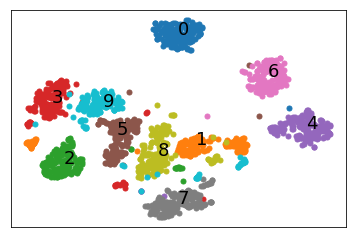

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.xticks([], [])
plt.yticks([], [])
for target in np.unique(ground_truth):
    selection = ground_truth==target
    X1, X2 = Tx[selection, 0], Tx[selection, 1]
    c1, c2 = np.median(X1), np.median(X2)
    plt.plot(X1, X2, 'o', ms=5)
    plt.text(c1, c2, target, fontsize=18)

# Quelques applications de décomposition

## Reconnaissance de visages par analyse PCA

In [11]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True, 
                               random_state=101)
train_faces = dataset.data[:350,:]
test_faces  = dataset.data[350:,:]
train_answers = dataset.target[:350]
test_answers = dataset.target[350:]

In [12]:
print(dataset.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [13]:
from sklearn.decomposition import RandomizedPCA
n_components = 25
Rpca = PCA(svd_solver='randomized', 
           n_components=n_components, 
           whiten=True)
Rpca.fit(train_faces)
print('Variance expliquée par %i composantes: %0.3f' 
      % (n_components, np.sum(Rpca.explained_variance_ratio_)))
compressed_train_faces = Rpca.transform(train_faces)
compressed_test_faces  = Rpca.transform(test_faces)

Variance expliquée par 25 composantes: 0.794


La personne représentée est le sujet 34


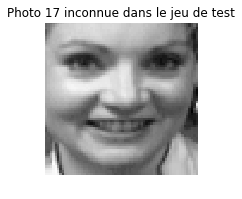

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

photo = 17
print('La personne représentée est le sujet %i' 
      % test_answers[photo])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Photo '+str(photo)+' inconnue dans le jeu de test')
plt.imshow(test_faces[photo].reshape(64,64), 
           cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [15]:
mask = compressed_test_faces[photo,] 
squared_errors = np.sum((compressed_train_faces - mask)**2,
                         axis=1)
minimum_error_face = np.argmin(squared_errors)
most_resembling = list(np.where(squared_errors < 20)[0])
print("Sujet le plus ressemblant dans le jeu d'entraînement: %i" 
      % train_answers[minimum_error_face])

Sujet le plus ressemblant dans le jeu d'entraînement: 34


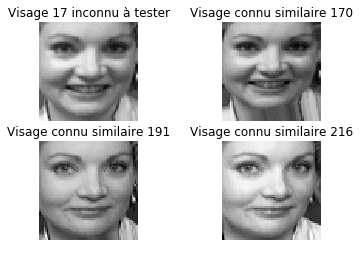

In [16]:
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Visage '+str(photo)+' inconnu à tester')
plt.imshow(test_faces[photo].reshape(64, 64), 
           cmap=plt.cm.gray, 
           interpolation='nearest')
for k,m in enumerate(most_resembling[:3]):
    plt.subplot(2, 2, 2+k)
    plt.title('Visage connu similaire '+str(m))
    plt.axis('off')
    plt.imshow(train_faces[m].reshape(64, 64), 
               cmap=plt.cm.gray, 
               interpolation='nearest')
plt.show()

## Extraction de sujets par factorisation NMF

In [17]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, 
                             categories = ['misc.forsale'], 
                             remove=('headers', 'footers', 'quotes'), 
                             random_state=101)
print('Posts: %i' % len(dataset.data))

Posts: 585


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, 
                             stop_words='english')
tfidf = vectorizer.fit_transform(dataset.data)

n_topics = 5
nmf = NMF(n_components=n_topics, 
          random_state=101).fit(tfidf)

In [19]:
feature_names = vectorizer.get_feature_names()
n_top_words = 15
for topic_idx, topic in enumerate(nmf.components_):
    print('Topic #%d:' % (topic_idx+1),)
    topics = topic.argsort()[:-n_top_words - 1:-1]
    print(' '.join([feature_names[i] for i in topics]))

Topic #1:
condition excellent asking offer best car old new sale 10 miles 000 tape cd power
Topic #2:
00 50 dos 20 10 15 cover 1st new 25 price man 40 shipping comics
Topic #3:
drive hard card floppy monitor meg ram disk motherboard vga modem brand scsi color internal
Topic #4:
email looking game games send interested mail thanks like edu good want package price list
Topic #5:
shipping vcr works stereo obo included amp plus great volume unc mathes gibbs radley remotes


In [20]:
print(nmf.components_[0,:].argsort()[:-n_top_words-1:-1])

[1075 1459  632 2463  740  888 2476 2415 2987   10 2305    1 3349  923
 2680]


In [21]:
word_index = 1075
print(vectorizer.get_feature_names()[word_index])

condition


## Suggestions cinématographiques

Important : Installez d'abord les fichiers de cinéma situés ici :
http://files.grouplens.org/datasets/movielens/ml-1m.zip
en tenant compte des explications du livre.

In [24]:
import os
print(os.getcwd())
os.chdir(".")          # Si vous avez besoin d'en changer ££
print(os.getcwd())

C:\Users\MonNom\PYDASC
C:\Users\MonNom\PYDASC


In [25]:
import pandas as pd
from scipy.sparse import csr_matrix
users = pd.read_table('ml-1m/users.dat', sep='::', 
        header=None, names=['user_id', 'gender', 
        'age', 'occupation', 'zip'], engine='python')
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', 
          header=None, names=['user_id', 'movie_id', 
          'rating', 'timestamp'], engine='python')
movies = pd.read_table('ml-1m/movies.dat', sep='::', 
         header=None, names=['movie_id', 'title', 
         'genres'], engine='python')
MovieLens = pd.merge(pd.merge(ratings, users), movies)

In [26]:
ratings_mtx_df = MovieLens.pivot_table(values='rating', 
        index='user_id', columns='title', fill_value=0)
movie_index = ratings_mtx_df.columns

In [27]:
from sklearn.decomposition import TruncatedSVD
recom = TruncatedSVD(n_components=15, random_state=101)
R = recom.fit_transform(ratings_mtx_df.values.T)

In [28]:
movie = 'Star Wars: Episode V - The Empire Strikes Back (1980)'
movie_idx = list(movie_index).index(movie)
print("movie index: %i" %movie_idx)
print(R[movie_idx])

movie index: 3154
[184.72254552 -17.77612872  47.33450866  51.4664494   47.92058216
  17.65033116  14.3574635  -12.82219207  17.51347857   5.46888807
   7.5430805   -0.57117869 -30.74032355   2.4088565  -22.50368497]


In [29]:
import numpy as np
correlation_matrix = np.corrcoef(R)
P = correlation_matrix[movie_idx]
print(list(movie_index[(P > 0.95) & (P < 1.0)]))

['Raiders of the Lost Ark (1981)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Terminator, The (1984)']
